In [103]:
import pandas as pd
import numpy as np
import os
print os.getcwd();

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

C:\Users\henrique\Desktop\Polytechnique\3rd year\Projet 3A


In [104]:
class Node:
    def __init__(self, parent, height=0):
        self.parent = parent
        self.height = height   
        
class UnionFind:
    def __init__(self, parents):
        self.edges = self.initializeEdges(parents)
        self.parents = self.initializeParents(parents)
        self.labels = self.computeLabels()        
    
    def initializeEdges(self, parents):
        edges = []
        for i, p in enumerate(parents):
            edges.append([i,p])
        return edges
    
    def initializeParents(self, parents):
        parents_nodes = []
        for p in parents:
            parents_nodes.append(Node(p,0))
        return parents_nodes
        
    
    def Find(self, i):
        #print "we want to find "+str(i)
        if self.parents[i].parent==i:
            return self.parents[i]
        else:
            a_i = self.Find(self.parents[i].parent)
            self.parents[i] = a_i
            return self.parents[i]
        
    def Union(self, i, j):
        a_i = self.Find(i)
        a_j = self.Find(j)
        #print "we unite " + str(i) + " and " +str(j)
        if a_i.parent==a_j.parent:
            return False
        elif a_i.height > a_j.height :
            a_j.parent = a_i
        elif a_i.height < a_j.height :
            a_i.parent = a_j
        else:
            a_j.parent = a_i
            a_i.height += 1
        return True
    
    def computeLabels(self):
        for e in self.edges:
            #print "we unite " + str(e[0]) + " and " + str(e[1])
            self.Union(e[0], e[1])
        return [p.parent for p in self.parents]
    
uf = UnionFind([0,1,2,1,3,2])
        

In [168]:
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np


class Point:
    def __init__(self, line, mode='file'):
        if(mode=='file'):
            stringarray = line.split(' ')
            self.coords = np.array([float(string) for string in stringarray
                                    if string != ''])
        else:
            self.coords = line
            
    def sqDist(self, point):
        return np.linalg.norm(self.coords - point.coords) ** 2

    def toString(self):
        np.set_printoptions(precision=3)
        #print("Point coordinates:\n", self.coords)      
        
class HillClimbing:
    def __init__(self, filename, kGraph, mode='coords'):
        self.cloud = self.readData(filename, mode)
        #print "cloud is "
        #for p in self.cloud:
        #    print p.coords
        self.neighbors = self.computeNeighbors(kGraph)
        self.density = self.computeDensity()
        self.parent = self.computeForest()
        self.label = self.computeLabels()

    def readData(self, filename, mode):
        if(mode=='coords'):
            cloud = []
            with open(filename, 'rb') as f:
                for line in f:
                    cloud.append(Point(line))
            f.close()
            return np.array(cloud)
        else: # in this case, we are reading a csv file
            df = pd.read_csv(filename)
            df2 = df.select_dtypes(include=['number'])
            cloud = [Point(x, mode='coords') for x in df2.values]
            return cloud

    def computeNeighbors(self, k):
        neighbors = np.zeros((len(self.cloud), k), dtype=int)
        for i, point1 in enumerate(self.cloud):
            distances = [point1.sqDist(point2) for point2 in self.cloud]
            neighbors[i] = np.argsort(distances)[1: k+1]
        return neighbors

    def computeDensity(self):
        density = np.zeros(len(self.cloud))
        for i, point1 in enumerate(self.cloud):
            
            avg_dist = np.mean(
                [point1.sqDist(self.cloud[j])
                 for j in self.neighbors[i]])
            density[i] = 1/np.sqrt(avg_dist)
        return density

    def computeForest(self):
        parent = np.arange(len(self.cloud))
        for i, point1 in enumerate(self.cloud):
            max_neighbor = self.neighbors[
                np.argmax(self.density[self.neighbors[i]])]
            #print(max_neighbor)
            if self.density[max_neighbor[0]] > self.density[i]:
                parent[i] = max_neighbor[0]
        return parent

    def computeLabels(self):
        #labels = np.zeros(len(self.cloud), dtype=int)
        
        uf = UnionFind(self.parent)
        sorted_labels = np.unique(uf.labels)
        n_labels = len(sorted_labels)        
        dic = {}
        for i, x in enumerate(sorted_labels):
            dic[x]=i
        labels = [dic[x] for x in uf.labels ]
        return labels
        
        '''for i, point1 in enumerate(self.cloud):
            idx = i
            uphill = self.parent[idx]
            while idx != uphill:
                idx = uphill
                uphill = self.parent[idx]
            labels[i] = uphill
        return labels'''
        
    
        
    def plotClusters(self, mode='own', labs=[], n_dim=3):
        if(mode=='own'):
            labs = self.label
        n_labels = len(np.unique(labs))
        
        points = np.array([point.coords for point in self.cloud])
        if(len(points[0])==2):
            cmap = sns.color_palette("hls", n_labels)
            fig, ax = plt.subplots()
            for i, label in enumerate(np.unique(self.label)):
                sub_points = points[np.where(self.label == label)]
                ax.scatter(sub_points[:, 0], sub_points[:, 1], c=cmap[i])
            plt.show()
        elif(n_dim>=3): # we only expect n_dim = 3 or 2, so here we assume its value is 3
            points = np.array([point.coords for point in self.cloud])
            df = pd.DataFrame(points)
            from sklearn import decomposition
            pca = decomposition.PCA(n_components=3)
            pca.fit(df)
            reduced_df = pca.transform(df)
            print "explained variance ratio: "
            print pca.explained_variance_ratio_
            fig = plt.figure(1, figsize=(4, 3))
            ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
            ax.scatter(reduced_df[:, 0], reduced_df[:, 1], reduced_df[:, 2], c=self.label)
        else:
            points = np.array([point.coords for point in self.cloud])
            df = pd.DataFrame(points)
            from sklearn import decomposition
            pca = decomposition.PCA(n_components=2)
            pca.fit(df)
            reduced_df = pca.transform(df)
            pca.explained_variance_ratio_
            import pylab
            pylab.scatter(reduced_df[:, 0], reduced_df[:, 1], c=labs)
            pylab.show()  
            
    def getLabels(self):
        return self.label

In [169]:
hc = HillClimbing('Dados.csv', 10, mode='dataframe')

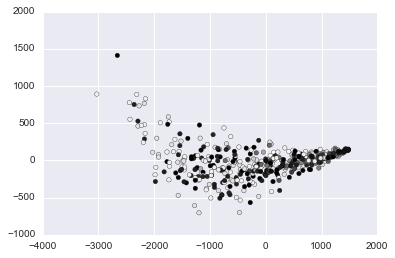

In [170]:
hc.plotClusters(n_dim=2)

In [171]:
df = pd.read_csv('Dados.csv')
dict = {' PG': 1, ' PF': 2, ' SG' : 3, ' SF' : 4, ' C' : 5}
position_labels = [dict[x] for x in df['PosicAbbrev']]

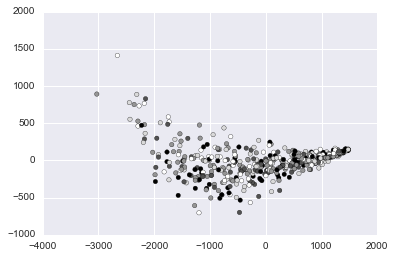

In [172]:
hc.plotClusters(mode='other', labs=position_labels, n_dim=2)

In [173]:
from sklearn.metrics import adjusted_rand_score
hill_climbing_labels = hc.getLabels()
print "Random index score: " + str(adjusted_rand_score(hill_climbing_labels, position_labels))

Random index score: 0.0010866477361


In [174]:
print sorted(hc.getLabels())
# There are more than a hundred different labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 8

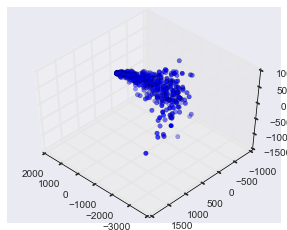

In [176]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(df2)
reduced_df = pca.transform(df2)
pca.explained_variance_ratio_
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(reduced_df[:, 0], reduced_df[:, 1], reduced_df[:, 2], cmap=position_labels)